# Simulating water quality<a id="top"></a>

_Developed by Davíd Brakenhoff (Artesia) on July 19, 2019_
<hr>

This notebook shows how to simulate water quality using the waterbalans module.

## Contents
- [Run an EAG](#1)
- [Load water quality parameters](#2)
- [Simulate water quality](#3)
- [Calculate concentrations](#4)
- [Visualize the results](#5)

First import the requisiste modules

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import waterbalans as wb

## [Run an EAG](#top)<a id="1"></a>

First use the function `wb.run_eag_by_name()` to simulate water quantity.

In [6]:
e = wb.run_eag_by_name("2250-EAG-2", csvdir="../../data/input_csv")

2019-07-23 11:55:46,064 | create_eag - INFO : Creating EAG object for '2250-EAG-2'
2019-07-23 11:55:46,088 | add_series_from_database - INFO : Parsing timeseries from database export and adding to EAG.
2019-07-23 11:55:47,925 | get_series - INFO : Adding FEWS timeseries 'Gemaal1Debiet Pomp 1': polder|Pompvolumes|60151_pomp_1|Vol.berekend.dag.
2019-07-23 11:55:49,380 | get_series - INFO : Adding FEWS timeseries 'Neerslag': meteo_meetstation_KNMI|ImportCAW|66005cal|P.meting.dagcal.
2019-07-23 11:55:50,733 | get_series - INFO : Adding FEWS timeseries 'Peil': polder|Statistiek|60151_onderbemaling|H.meting.gem.
2019-07-23 11:55:51,623 | get_series - INFO : Adding FEWS timeseries 'Verdamping': meteo_meetstation_KNMI|ImportCAW|66002_VerdampingCAL|E.metingcal.
2019-07-23 11:55:52,022 | add_timeseries - INFO : Adding timeseries 'Gemaal1' to EAG manually
2019-07-23 11:55:52,025 | add_timeseries - INFO : Filled 2187 NaN-values with '0.0' in series Gemaal1.
2019-07-23 11:55:52,033 | add_timeseries

## [Load water quality parameters](#top)<a id="2"></a>

Load the water quality parameters for phosphorous.

In [7]:
# bestand met concentraties van stof per flux
fosfor = pd.read_csv(r"../../data/input_csv/stoffen_fosfor_85_2250-EAG-2.csv", delimiter=";", decimal=",")

Unfortunately, the current CSV file does not comply with the requirements of the waterbalans module. This is something that will be improved in the future. Therefore we have to modify the DataFrame slightly:
- capitalize column names
- replace "Riolering"  with "q_cso"
- convert "Waarde" and "Stofincrement" to numeric values

In [8]:
fosfor.columns = [icol.capitalize() for icol in fosfor.columns]
fosfor.replace("Riolering", "q_cso", inplace=True)
fosfor["Waarde"] = pd.to_numeric(fosfor["Waarde"])
fosfor["Stofincrement"] = pd.to_numeric(fosfor["Stofincrement"])
fosfor

,Eagid,Eagcode,Stofnaam,Inlaattype,Reekstype,Waardealfa,Waarde,Stofincrement,Eenheid
0,85,2250-EAG-2,Fosfor,Afstroming,Constant,NaN,0.01,0.60,mgP/l
1,85,2250-EAG-2,Fosfor,Berekende inlaat,Constant,NaN,0.25,0.10,mgP/l
2,85,2250-EAG-2,Fosfor,Drain,Constant,NaN,0.40,0.60,mgP/l
3,85,2250-EAG-2,Fosfor,Inlaat1,Constant,NaN,0.10,0.05,mgP/l
4,85,2250-EAG-2,Fosfor,Inlaat2,Constant,NaN,0.10,0.05,mgP/l
5,85,2250-EAG-2,Fosfor,Inlaat3,Constant,NaN,0.00,0.00,mgP/l
6,85,2250-EAG-2,Fosfor,Inlaat4,Constant,NaN,0.00,0.00,mgP/l
7,85,2250-EAG-2,Fosfor,Kwel,Constant,NaN,0.20,0.30,mgP/l
8,85,2250-EAG-2,Fosfor,Neerslag,Constant,NaN,0.00,0.02,mgP/l
9,85,2250-EAG-2,Fosfor,q_cso,Constant,NaN,3.00,0.00,mgP/l


## [Simulate water quality](#top)<a id="3"></a>

Simulate the water quality for both the base parameters (the concentration in column "Waarde") and the upper boundary (column "Waarde" + column "Stofincrement").

Unlike the simulation for water quantity, the water quality simulation returns three DataFrames containing the mass coming into the system, the mass going out of the system and the total mass stored in the system. These mass-fluxes can then be used to calculate concentration. 

_**Note**: we are thinking about making the simulation of water quality more similar in behavior to that of water quantity._

In [9]:
# Simuleer de waterkwaliteit (ondergrens en bovengrens)
mass_in, mass_out, mass_fosfor = e.simulate_wq(fosfor)
mass_in_max, mass_out_max, mass_fosfor_max = e.simulate_wq(fosfor, increment=True)

2019-07-23 12:05:02,607 | simulate_wq - INFO : Simulating water quality: 2250-EAG-2...
2019-07-23 12:05:10,215 | simulate_wq - INFO : Simulation water quality succesfully completed in 7.6s.
2019-07-23 12:05:10,218 | simulate_wq - INFO : Simulating water quality: 2250-EAG-2...
2019-07-23 12:05:17,835 | simulate_wq - INFO : Simulation water quality succesfully completed in 7.6s.


## [Calculate concentrations](#top)<a id="3"></a>

The concentration can be calculated using the storage of the Water bucket.

In [10]:
# Bereken de concentratie
C_fosfor = mass_fosfor / e.water.storage["storage"]
C_fosfor_max = mass_fosfor_max / e.water.storage["storage"]

## [Visualize the results](#top)<a id="4"></a>

In the Eag-plotting module there is a plot for displaying the incoming and outgoing mass of a particular substance over a certain period of time. In this case we're looking at phosphorous loading per year. The plot can be created with `e.plot.wq_loading()` and requires the in- and outgoing mass DataFrames as input.

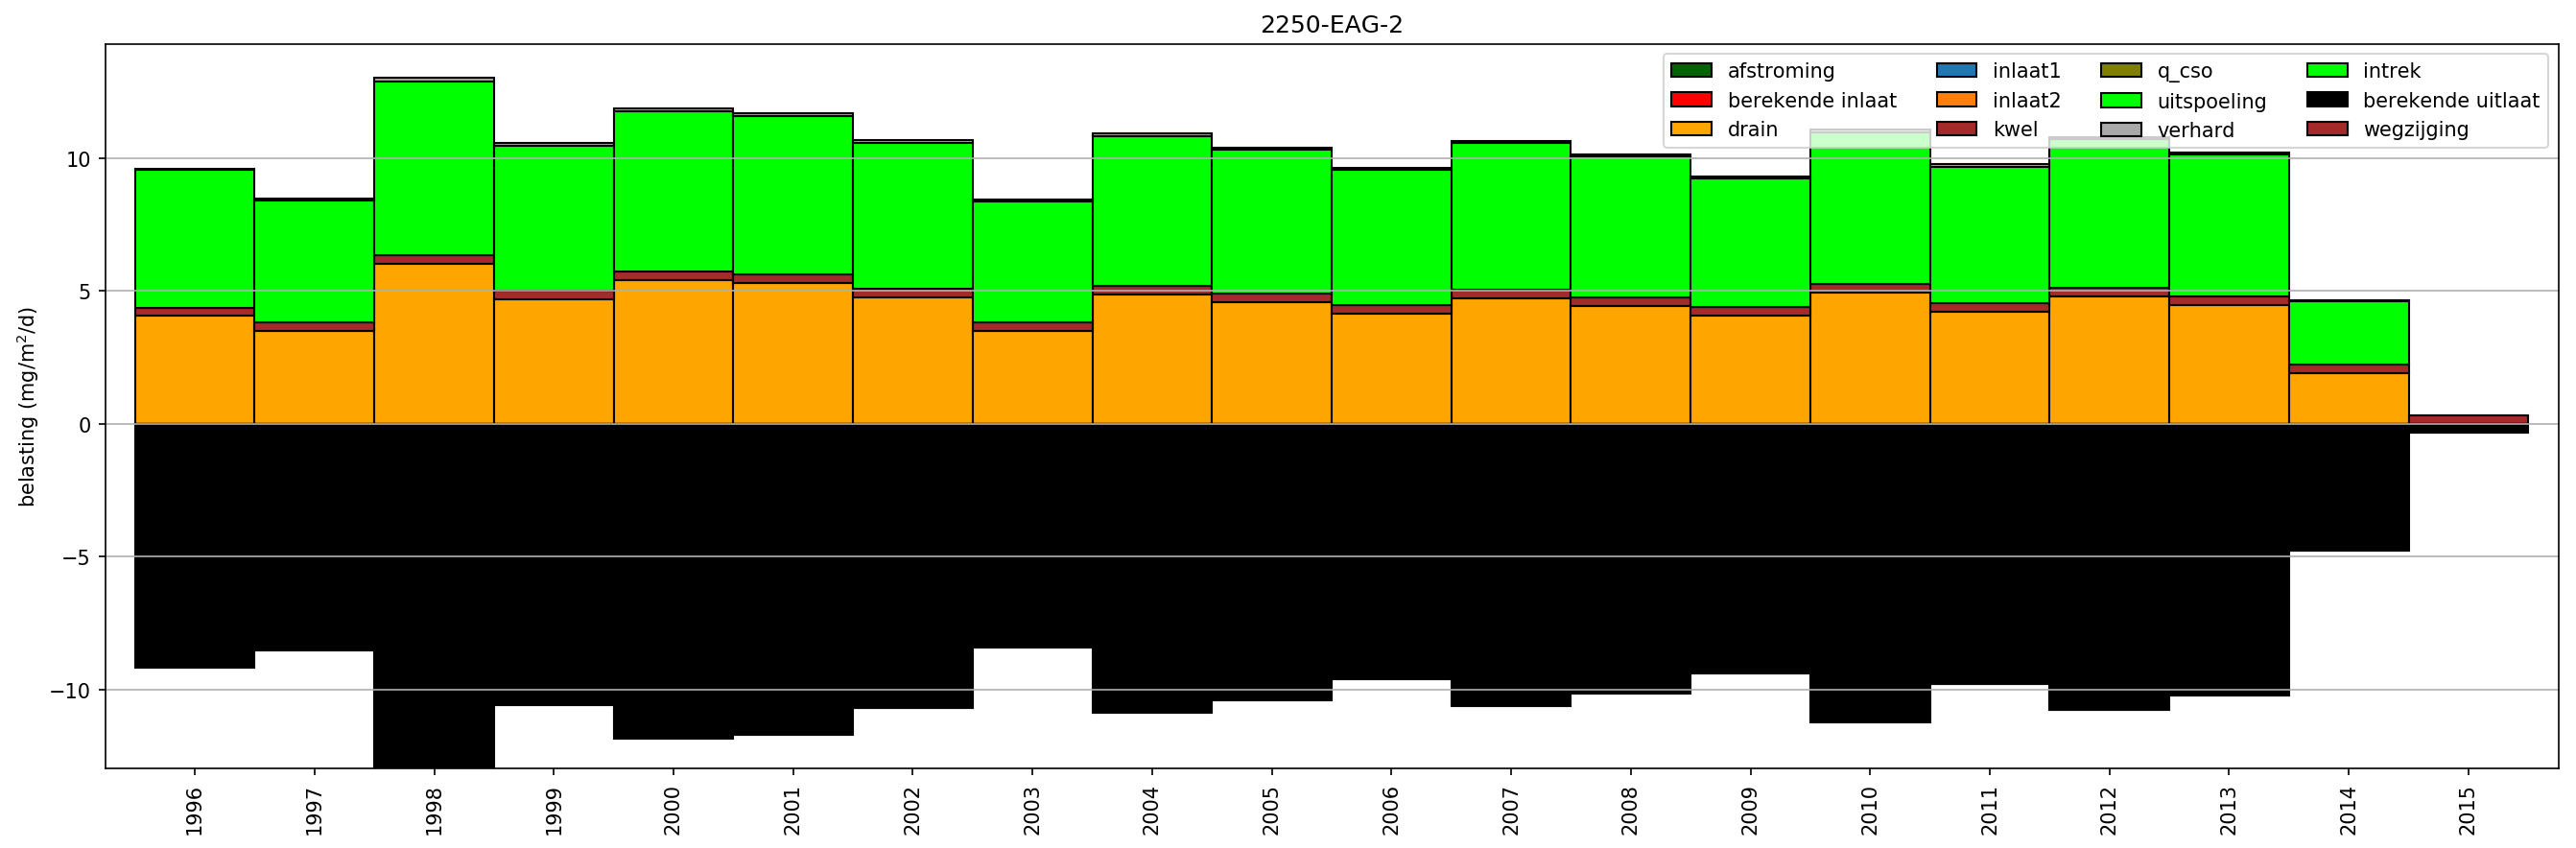

In [11]:
ax = e.plot.wq_loading(mass_in, mass_out, tmax="2015")

Plotting the concentration manually

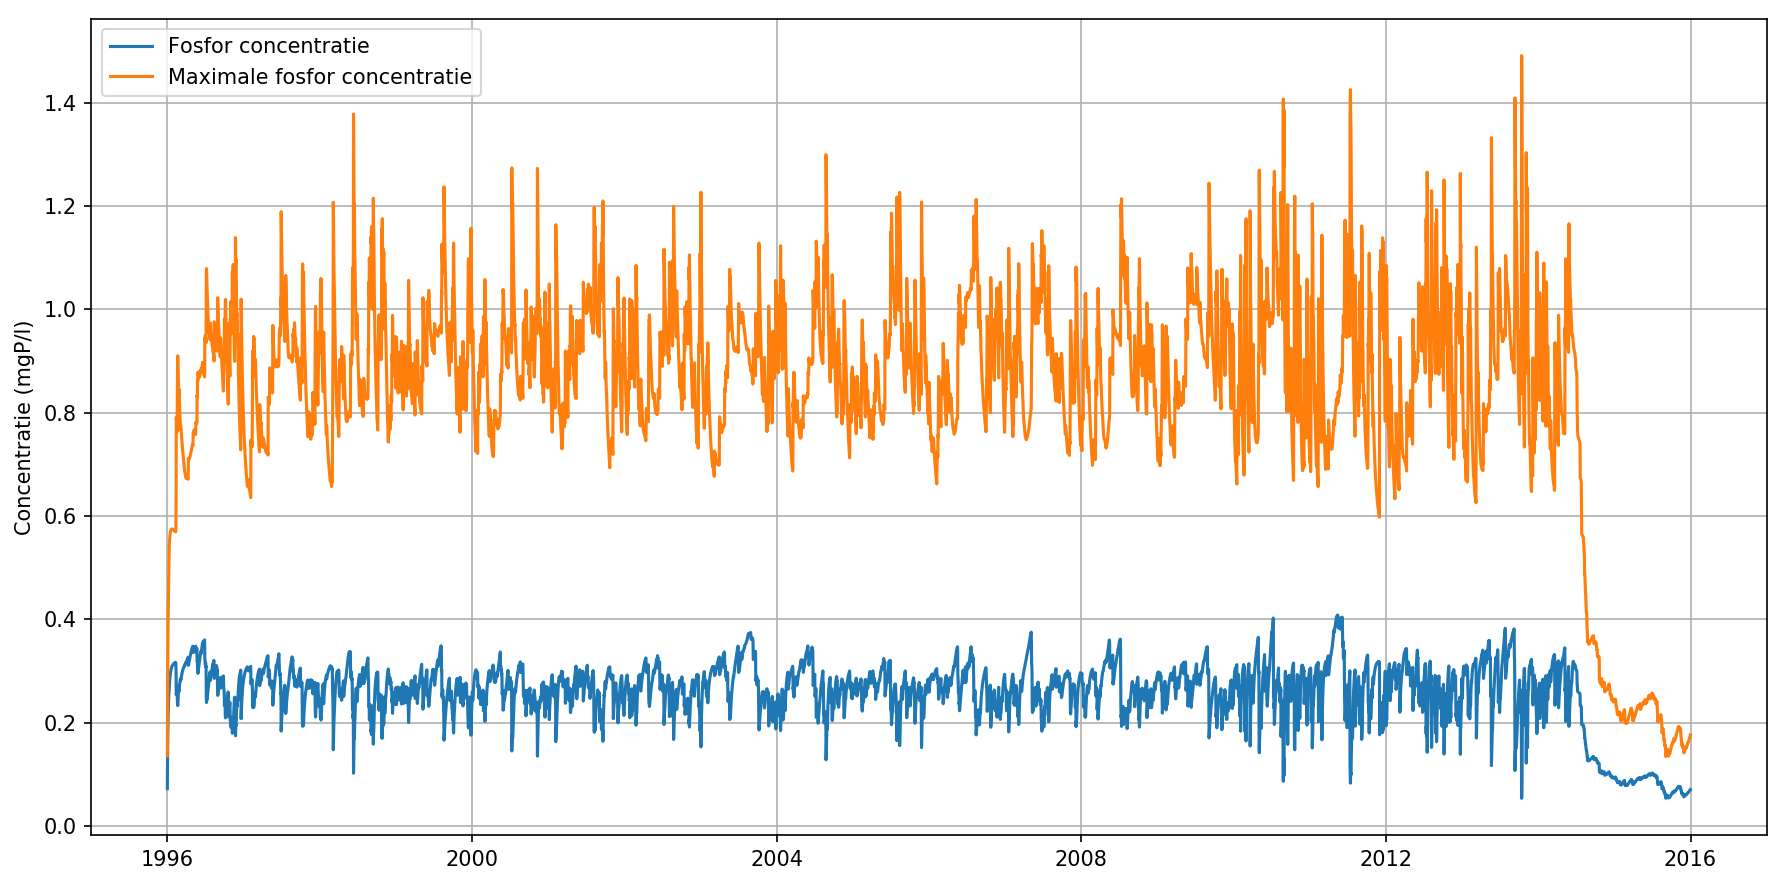

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=150)
ax.plot(C_fosfor.loc[:"2015"].index, C_fosfor.loc[:"2015"], label="Fosfor concentratie")
ax.plot(C_fosfor_max.loc[:"2015"].index, C_fosfor_max.loc[:"2015"], label="Maximale fosfor concentratie")
ax.legend(loc="best")
ax.set_ylabel("Concentratie (mgP/l)")
ax.grid(b=True)
fig.tight_layout()